#Installations

In [1]:
!pip install torchsummary

# Imports

In [2]:
# Importing torch packages 
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.optim.lr_scheduler import StepLR
from tqdm import tqdm
from torchsummary import summary
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt

In [4]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                       transforms.RandomRotation((-15.0, 15.0), fill=(1,)),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])

In [5]:
train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw
Processing...
Done!


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:469: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [6]:
SEED = 1

# If CUDA is available 
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments 
dataloader_args = dict(shuffle=True, batch_size=64, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


In [7]:
class BatchNorm(nn.BatchNorm2d):
    def __init__(self, num_features, eps=1e-05, momentum=0.1, weight=True, bias=True):
        super().__init__(num_features, eps=eps, momentum=momentum)
        self.weight.data.fill_(1.0)
        self.bias.data.fill_(0.0)
        self.weight.requires_grad = weight
        self.bias.requires_grad = bias

class GhostBatchNorm(BatchNorm):
    def __init__(self, num_features, num_splits, **kw):
        super().__init__(num_features, **kw)
        self.num_splits = num_splits
        self.register_buffer('running_mean', torch.zeros(num_features * self.num_splits))
        self.register_buffer('running_var', torch.ones(num_features * self.num_splits))

    def train(self, mode=True):
        if (self.training is True) and (mode is False):  
            self.running_mean = torch.mean(self.running_mean.view(self.num_splits, self.num_features), dim=0).repeat(
                self.num_splits)
            self.running_var = torch.mean(self.running_var.view(self.num_splits, self.num_features), dim=0).repeat(
                self.num_splits)
        return super().train(mode)

    def forward(self, input):
        N, C, H, W = input.shape
        if self.training or not self.track_running_stats:
            return F.batch_norm(
                input.view(-1, C * self.num_splits, H, W), self.running_mean, self.running_var,
                self.weight.repeat(self.num_splits), self.bias.repeat(self.num_splits),
                True, self.momentum, self.eps).view(N, C, H, W)
        else:
            return F.batch_norm(
                input, self.running_mean[:self.num_features], self.running_var[:self.num_features],
                self.weight, self.bias, False, self.momentum, self.eps)

In [8]:
gbn_splits = 4
class Net(nn.Module):
  def __init__(self, batch_normalization_type="BN"):
    super(Net, self).__init__() 
    self.conv1 = nn.Sequential(
        # Input=28x28x1 Kernel=3x3x1x10 Output=28x28x10 RF=3x3
        nn.Conv2d(in_channels=1, out_channels=10, kernel_size=(3, 3), padding=1, bias=False), 
        nn.ReLU(),
        nn.BatchNorm2d(10) if batch_normalization_type=="BN" else GhostBatchNorm(10, gbn_splits),
        nn.Dropout(0.04),
        # Input=28x28x10 Kernel=3x3x10x10 Output=28x28x10 RF=5x5
        nn.Conv2d(in_channels=10, out_channels=10, kernel_size=(3, 3), padding=1, bias=False), 
        nn.ReLU(),
        nn.BatchNorm2d(10) if batch_normalization_type=="BN" else GhostBatchNorm(10, gbn_splits),
        nn.Dropout(0.04) #output_size=28x28x10
        ) 
    
    #Input=28x28x10 Output=14x14x10 RF=6x6
    #output_size=14x14x10
    self.conv2 = nn.Sequential(
        nn.MaxPool2d(kernel_size=2, stride=2), 
    )
    
    self.conv3 = nn.Sequential(
        #Input=14x14x10 Kernel=3x3x10x10 Output=12x12x10 RF=10x10
        nn.Conv2d(in_channels=10, out_channels=10, kernel_size=(3, 3), padding=0, bias=False), 
        nn.ReLU(),
        nn.BatchNorm2d(10) if batch_normalization_type=="BN" else GhostBatchNorm(10, gbn_splits),
        nn.Dropout(0.04),
        #Input=12x12x10 Kernel=3x3x10x12 Output=10x10x12 RF=14x14
        nn.Conv2d(in_channels=10, out_channels=12, kernel_size=(3, 3), padding=0, bias=False), 
        nn.ReLU(),
        nn.BatchNorm2d(12) if batch_normalization_type=="BN" else GhostBatchNorm(12, gbn_splits),
        nn.Dropout(0.04),
        #Input=10x10x12 Kernel=3x3x12x16 Output=8x8x16 RF=18x18
        nn.Conv2d(in_channels=12, out_channels=16, kernel_size=(3, 3), padding=0, bias=False), 
        nn.ReLU(),            
        nn.BatchNorm2d(16) if batch_normalization_type=="BN" else GhostBatchNorm(16, gbn_splits),
        nn.Dropout(0.04),
        #Input=8x8x16 Kernel=3x3x16x16 Output=6x6x16 RF=22x22
        nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=0, bias=False), 
        nn.ReLU(),         
        nn.BatchNorm2d(16) if batch_normalization_type=="BN" else GhostBatchNorm(16, gbn_splits),
        nn.Dropout(0.04) #output_size=6x6x16
        ) 

    self.conv4 = nn.Sequential(
        #Input=6x6x16 Kernel=3x3x16x16 Output=4x4x16 RF=26x26
        nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=0, bias=False), 
        nn.ReLU(),
        nn.BatchNorm2d(16) if batch_normalization_type=="BN" else GhostBatchNorm(16, gbn_splits),
        #Input=4x4x16 Kernel=4x4x16x16 Output=1x1x16
        nn.AvgPool2d(kernel_size=(4,4)), 
        #Input=1x1x16 Kernel=1x1x16x10 Output=1x1x10
        nn.Conv2d(in_channels=16, out_channels=10, kernel_size=(1, 1), padding=0, bias=False) 
        ) 


  def forward(self, x):
    x = self.conv1(x)
    x = self.conv2(x)
    x = self.conv3(x)
    x = self.conv4(x)
    x = x.view(-1, 10)
    return F.log_softmax(x, dim=1)

In [9]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 10, 28, 28]              90
              ReLU-2           [-1, 10, 28, 28]               0
       BatchNorm2d-3           [-1, 10, 28, 28]              20
           Dropout-4           [-1, 10, 28, 28]               0
            Conv2d-5           [-1, 10, 28, 28]             900
              ReLU-6           [-1, 10, 28, 28]               0
       BatchNorm2d-7           [-1, 10, 28, 28]              20
           Dropout-8           [-1, 10, 28, 28]               0
         MaxPool2d-9           [-1, 10, 14, 14]               0
           Conv2d-10           [-1, 10, 12, 12]             900
             ReLU-11           [-1, 10, 12, 12]               0
      BatchNorm2d-12           [-1, 10, 12, 12]              20
          Dropout-13           [-1, 10, 12, 12]               0
           Conv2d-14           [-1, 12,

In [10]:
def train(model, device, train_loader, optimizer, epoch, reg, lambda1, lambda2, train_losses, train_acc):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation 
    #because PyTorch accumulates the gradients on subsequent backward passes. 
    #When you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    #Calculate Loss
    regularization_loss1 = 0
    regularization_loss2 = 0
    #No Regularization
    if (reg=='None'): 
      loss = F.nll_loss(y_pred, target)
      train_losses.append(loss)
    
    #Loss with L1
    elif (reg=='L1'): 
      loss = F.nll_loss(y_pred, target)
      for param in model.parameters():
        regularization_loss1 += torch.norm(param,1)
      loss += (lambda1*regularization_loss1)
      train_losses.append(loss)
    
    #Loss with L2
    elif (reg=='L2'): 
      loss = F.nll_loss(y_pred, target)
      for param in model.parameters():
        regularization_loss2 += torch.norm(param,2)
      loss += (lambda2*regularization_loss2)
      train_losses.append(loss)
    
    #Loss with L1 and L2
    elif (reg=='L1L2'): 
      loss = F.nll_loss(y_pred, target)
      for param in model.parameters():
        regularization_loss1 += torch.norm(param,1)
        regularization_loss2 += torch.norm(param,2)
      loss += (lambda1*regularization_loss1+lambda2*regularization_loss2)
      train_losses.append(loss)

    #Loss with GBN 
    elif (reg== 'GBN'): 
      loss = F.nll_loss(y_pred, target)
      train_losses.append(loss)
    
    #Loss with GBN, L1 and L2
    else: 
      loss = F.nll_loss(y_pred, target)
      for param in model.parameters():
        regularization_loss1 += torch.norm(param,1)
        regularization_loss2 += torch.norm(param,2)
      loss += (lambda1*regularization_loss1+lambda2*regularization_loss2)
      train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # get the index of the max log-probability
    pred = y_pred.argmax(dim=1, keepdim=True)  
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item():0.3f} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100.*correct/processed)

def test(model, device, test_loader, test_losses, test_acc, misclassified_images, misclassified=False):
    model.eval()
    test_loss = 0
    correct = 0
    num_misclassified = 0
    with torch.no_grad():
        for data, target in test_loader:
            # if misclassified: batch_images = data batch_target = target
            data, target = data.to(device), target.to(device)
            output = model(data)
            # sum up batch loss
            test_loss += F.nll_loss(output, target, reduction='sum').item()  
            # get the index of the max log-probability
            pred = output.argmax(dim=1, keepdim=True)  
            correct += pred.eq(target.view_as(pred)).sum().item()
            if misclassified:
              if num_misclassified <= 25:
                incorrect_id = ~pred.eq(target.view_as(pred))
                
                if incorrect_id.sum().item() != 0:
                  num_misclassified += incorrect_id.sum().item()
                  misclassified_images.append((data[incorrect_id], pred[incorrect_id], target.view_as(pred)[incorrect_id]))


    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc.append(100. * correct / len(test_loader.dataset))

In [11]:
def run_models(model, device, epochs, reg, lambda1 = 0.0002, lambda2 = 0.0001):
  train_losses = []
  test_losses = []
  train_acc = []
  test_acc = []
  misclassified_images = []
  model = model.to(device)
  optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
  scheduler = StepLR(optimizer, step_size=6, gamma=0.1)

  for epoch in range(epochs):
      print("EPOCH:", epoch+1)
      train(model, device, train_loader, optimizer, epoch, reg, lambda1, lambda2, train_losses, train_acc)
      scheduler.step()
      if epoch !=24:
        test(model, device, test_loader, test_losses, test_acc, misclassified_images)
      else:
        test(model, device, test_loader, test_losses, test_acc, misclassified_images, misclassified=True)
  
  return test_losses, test_acc, misclassified_images

## Ghost Batch Normalization

In [12]:
#Ghost Batch Normalization
gbn_loss, gbn_acc, gbn_misclassified = run_models(Net(batch_normalization_type="GBN"), device, 25, "None")

  0%|          | 0/938 [00:00<?, ?it/s]

EPOCH: 1


  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0551, Accuracy: 9825/10000 (98.25%)

EPOCH: 2


  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0331, Accuracy: 9886/10000 (98.86%)

EPOCH: 3


  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0319, Accuracy: 9895/10000 (98.95%)

EPOCH: 4


  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0261, Accuracy: 9917/10000 (99.17%)

EPOCH: 5


  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0278, Accuracy: 9905/10000 (99.05%)

EPOCH: 6


  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0248, Accuracy: 9923/10000 (99.23%)

EPOCH: 7


  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0193, Accuracy: 9936/10000 (99.36%)

EPOCH: 8


  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0185, Accuracy: 9943/10000 (99.43%)

EPOCH: 9


  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0182, Accuracy: 9943/10000 (99.43%)

EPOCH: 10


  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0191, Accuracy: 9937/10000 (99.37%)

EPOCH: 11


  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0176, Accuracy: 9947/10000 (99.47%)

EPOCH: 12


  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0172, Accuracy: 9943/10000 (99.43%)

EPOCH: 13


  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0175, Accuracy: 9946/10000 (99.46%)

EPOCH: 14


  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0176, Accuracy: 9946/10000 (99.46%)

EPOCH: 15


  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0176, Accuracy: 9943/10000 (99.43%)

EPOCH: 16


  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0172, Accuracy: 9946/10000 (99.46%)

EPOCH: 17


  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0173, Accuracy: 9948/10000 (99.48%)

EPOCH: 18


  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0173, Accuracy: 9947/10000 (99.47%)

EPOCH: 19


  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0178, Accuracy: 9944/10000 (99.44%)

EPOCH: 20


  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0178, Accuracy: 9949/10000 (99.49%)

EPOCH: 21


  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0174, Accuracy: 9945/10000 (99.45%)

EPOCH: 22


  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0172, Accuracy: 9943/10000 (99.43%)

EPOCH: 23


  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0173, Accuracy: 9947/10000 (99.47%)

EPOCH: 24


  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0174, Accuracy: 9949/10000 (99.49%)

EPOCH: 25


Loss=0.011 Batch_id=937 Accuracy=98.74: 100%|██████████| 938/938 [00:19<00:00, 48.01it/s]



Test set: Average loss: 0.0172, Accuracy: 9949/10000 (99.49%)



## With L1 Regularization

In [13]:
l1_loss, l1_acc, l1_misclassified = run_models(Net(), device, 25, "L1")

  0%|          | 0/938 [00:00<?, ?it/s]

EPOCH: 1


  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0486, Accuracy: 9863/10000 (98.63%)

EPOCH: 2


  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0414, Accuracy: 9873/10000 (98.73%)

EPOCH: 3


  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0407, Accuracy: 9860/10000 (98.60%)

EPOCH: 4


  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0386, Accuracy: 9878/10000 (98.78%)

EPOCH: 5


  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0303, Accuracy: 9907/10000 (99.07%)

EPOCH: 6


  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0411, Accuracy: 9882/10000 (98.82%)

EPOCH: 7


  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0177, Accuracy: 9940/10000 (99.40%)

EPOCH: 8


  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0166, Accuracy: 9941/10000 (99.41%)

EPOCH: 9


  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0165, Accuracy: 9942/10000 (99.42%)

EPOCH: 10


  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0157, Accuracy: 9943/10000 (99.43%)

EPOCH: 11


  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0162, Accuracy: 9946/10000 (99.46%)

EPOCH: 12


  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0158, Accuracy: 9948/10000 (99.48%)

EPOCH: 13


  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0155, Accuracy: 9946/10000 (99.46%)

EPOCH: 14


  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0153, Accuracy: 9943/10000 (99.43%)

EPOCH: 15


  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0156, Accuracy: 9947/10000 (99.47%)

EPOCH: 16


  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0160, Accuracy: 9944/10000 (99.44%)

EPOCH: 17


  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0153, Accuracy: 9943/10000 (99.43%)

EPOCH: 18


  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0151, Accuracy: 9945/10000 (99.45%)

EPOCH: 19


  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0149, Accuracy: 9944/10000 (99.44%)

EPOCH: 20


  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0155, Accuracy: 9944/10000 (99.44%)

EPOCH: 21


  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0158, Accuracy: 9945/10000 (99.45%)

EPOCH: 22


  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0155, Accuracy: 9944/10000 (99.44%)

EPOCH: 23


  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0152, Accuracy: 9947/10000 (99.47%)

EPOCH: 24


  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0150, Accuracy: 9945/10000 (99.45%)

EPOCH: 25


Loss=0.087 Batch_id=937 Accuracy=99.12: 100%|██████████| 938/938 [00:20<00:00, 45.27it/s]



Test set: Average loss: 0.0148, Accuracy: 9942/10000 (99.42%)



## With L2 Regularization

In [14]:
l2_loss, l2_acc, l2_misclassified = run_models(Net(), device, 25, "L2")

  0%|          | 0/938 [00:00<?, ?it/s]

EPOCH: 1


  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0382, Accuracy: 9889/10000 (98.89%)

EPOCH: 2


  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0312, Accuracy: 9910/10000 (99.10%)

EPOCH: 3


  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0268, Accuracy: 9917/10000 (99.17%)

EPOCH: 4


  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0281, Accuracy: 9905/10000 (99.05%)

EPOCH: 5


  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0248, Accuracy: 9925/10000 (99.25%)

EPOCH: 6


  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0199, Accuracy: 9938/10000 (99.38%)

EPOCH: 7


  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0179, Accuracy: 9948/10000 (99.48%)

EPOCH: 8


  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0180, Accuracy: 9944/10000 (99.44%)

EPOCH: 9


  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0169, Accuracy: 9946/10000 (99.46%)

EPOCH: 10


  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0175, Accuracy: 9946/10000 (99.46%)

EPOCH: 11


  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0180, Accuracy: 9944/10000 (99.44%)

EPOCH: 12


  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0167, Accuracy: 9952/10000 (99.52%)

EPOCH: 13


  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0170, Accuracy: 9953/10000 (99.53%)

EPOCH: 14


  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0171, Accuracy: 9950/10000 (99.50%)

EPOCH: 15


  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0165, Accuracy: 9952/10000 (99.52%)

EPOCH: 16


  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0166, Accuracy: 9950/10000 (99.50%)

EPOCH: 17


  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0160, Accuracy: 9950/10000 (99.50%)

EPOCH: 18


  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0169, Accuracy: 9943/10000 (99.43%)

EPOCH: 19


  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0165, Accuracy: 9949/10000 (99.49%)

EPOCH: 20


  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0164, Accuracy: 9953/10000 (99.53%)

EPOCH: 21


  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0160, Accuracy: 9949/10000 (99.49%)

EPOCH: 22


  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0166, Accuracy: 9952/10000 (99.52%)

EPOCH: 23


  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0163, Accuracy: 9952/10000 (99.52%)

EPOCH: 24


  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0166, Accuracy: 9950/10000 (99.50%)

EPOCH: 25


Loss=0.090 Batch_id=937 Accuracy=99.11: 100%|██████████| 938/938 [00:20<00:00, 46.89it/s]



Test set: Average loss: 0.0161, Accuracy: 9948/10000 (99.48%)



## With L1 and L2 Regularization

In [15]:
l1l2_loss, l1l2_acc, l1l2_misclassified = run_models(Net(), device, 25, "L1L2")

  0%|          | 0/938 [00:00<?, ?it/s]

EPOCH: 1


  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0441, Accuracy: 9869/10000 (98.69%)

EPOCH: 2


  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0377, Accuracy: 9890/10000 (98.90%)

EPOCH: 3


  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0365, Accuracy: 9883/10000 (98.83%)

EPOCH: 4


  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0290, Accuracy: 9902/10000 (99.02%)

EPOCH: 5


  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0299, Accuracy: 9903/10000 (99.03%)

EPOCH: 6


  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0311, Accuracy: 9904/10000 (99.04%)

EPOCH: 7


  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0180, Accuracy: 9941/10000 (99.41%)

EPOCH: 8


  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0172, Accuracy: 9943/10000 (99.43%)

EPOCH: 9


  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0172, Accuracy: 9945/10000 (99.45%)

EPOCH: 10


  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0171, Accuracy: 9945/10000 (99.45%)

EPOCH: 11


  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0160, Accuracy: 9947/10000 (99.47%)

EPOCH: 12


  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0165, Accuracy: 9938/10000 (99.38%)

EPOCH: 13


  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0166, Accuracy: 9942/10000 (99.42%)

EPOCH: 14


  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0159, Accuracy: 9943/10000 (99.43%)

EPOCH: 15


  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0166, Accuracy: 9940/10000 (99.40%)

EPOCH: 16


  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0160, Accuracy: 9943/10000 (99.43%)

EPOCH: 17


  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0160, Accuracy: 9946/10000 (99.46%)

EPOCH: 18


  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0167, Accuracy: 9941/10000 (99.41%)

EPOCH: 19


  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0160, Accuracy: 9943/10000 (99.43%)

EPOCH: 20


  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0166, Accuracy: 9941/10000 (99.41%)

EPOCH: 21


  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0154, Accuracy: 9944/10000 (99.44%)

EPOCH: 22


  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0160, Accuracy: 9945/10000 (99.45%)

EPOCH: 23


  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0156, Accuracy: 9947/10000 (99.47%)

EPOCH: 24


  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0167, Accuracy: 9942/10000 (99.42%)

EPOCH: 25


Loss=0.126 Batch_id=937 Accuracy=99.03: 100%|██████████| 938/938 [00:22<00:00, 42.41it/s]



Test set: Average loss: 0.0159, Accuracy: 9946/10000 (99.46%)



## Ghost Batch Normalization with L1 and L2 regularization

In [16]:
gbn_l1l2_loss, gbn_l1l2_acc, gbn_l1l2_misclassified = run_models(Net(batch_normalization_type="GBN"), device, 25, "L1L2")

  0%|          | 0/938 [00:00<?, ?it/s]

EPOCH: 1


  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0523, Accuracy: 9836/10000 (98.36%)

EPOCH: 2


  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0486, Accuracy: 9846/10000 (98.46%)

EPOCH: 3


  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0378, Accuracy: 9878/10000 (98.78%)

EPOCH: 4


  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0349, Accuracy: 9889/10000 (98.89%)

EPOCH: 5


  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0298, Accuracy: 9905/10000 (99.05%)

EPOCH: 6


  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0337, Accuracy: 9882/10000 (98.82%)

EPOCH: 7


  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0214, Accuracy: 9931/10000 (99.31%)

EPOCH: 8


  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0192, Accuracy: 9937/10000 (99.37%)

EPOCH: 9


  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0192, Accuracy: 9937/10000 (99.37%)

EPOCH: 10


  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0190, Accuracy: 9938/10000 (99.38%)

EPOCH: 11


  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0174, Accuracy: 9946/10000 (99.46%)

EPOCH: 12


  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0186, Accuracy: 9936/10000 (99.36%)

EPOCH: 13


  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0178, Accuracy: 9941/10000 (99.41%)

EPOCH: 14


  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0176, Accuracy: 9941/10000 (99.41%)

EPOCH: 15


  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0173, Accuracy: 9942/10000 (99.42%)

EPOCH: 16


  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0178, Accuracy: 9941/10000 (99.41%)

EPOCH: 17


  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0176, Accuracy: 9942/10000 (99.42%)

EPOCH: 18


  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0175, Accuracy: 9944/10000 (99.44%)

EPOCH: 19


  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0179, Accuracy: 9942/10000 (99.42%)

EPOCH: 20


  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0174, Accuracy: 9943/10000 (99.43%)

EPOCH: 21


  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0176, Accuracy: 9940/10000 (99.40%)

EPOCH: 22


  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0176, Accuracy: 9941/10000 (99.41%)

EPOCH: 23


  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0182, Accuracy: 9940/10000 (99.40%)

EPOCH: 24


  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0176, Accuracy: 9942/10000 (99.42%)

EPOCH: 25


Loss=0.109 Batch_id=937 Accuracy=98.78: 100%|██████████| 938/938 [00:23<00:00, 39.63it/s]



Test set: Average loss: 0.0174, Accuracy: 9942/10000 (99.42%)



# Results

Text(0, 0.5, 'NLL Loss')

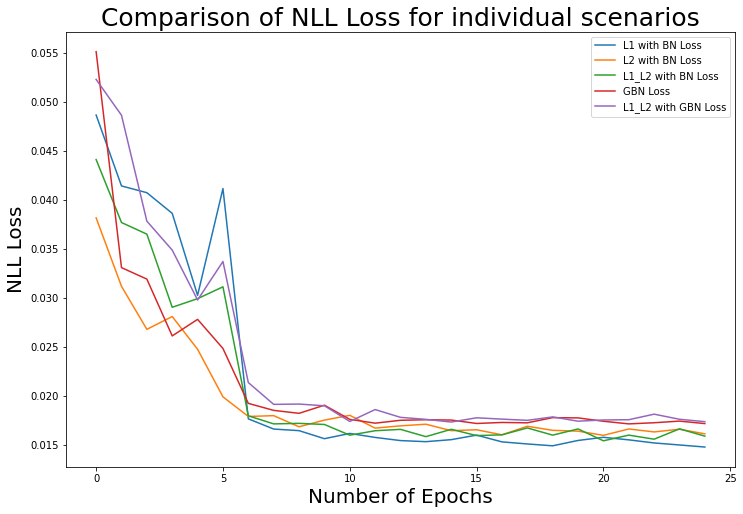

In [21]:
loss_df = pd.DataFrame({'L1 with BN Loss': l1_loss, 'L2 with BN Loss':l2_loss, 
                        'L1_L2 with BN Loss':l1l2_loss, 'GBN Loss':gbn_loss, 'L1_L2 with GBN Loss': gbn_l1l2_loss})
fig, ax = plt.subplots(figsize = (12, 8))
loss_plot = loss_df.plot(ax = ax)
ax.set_title('Comparison of NLL Loss for individual scenarios', fontsize=25)
ax.set_xlabel('Number of Epochs', fontsize=20)
ax.set_ylabel('NLL Loss', fontsize=20)

Text(0, 0.5, 'Validation Accuracy')

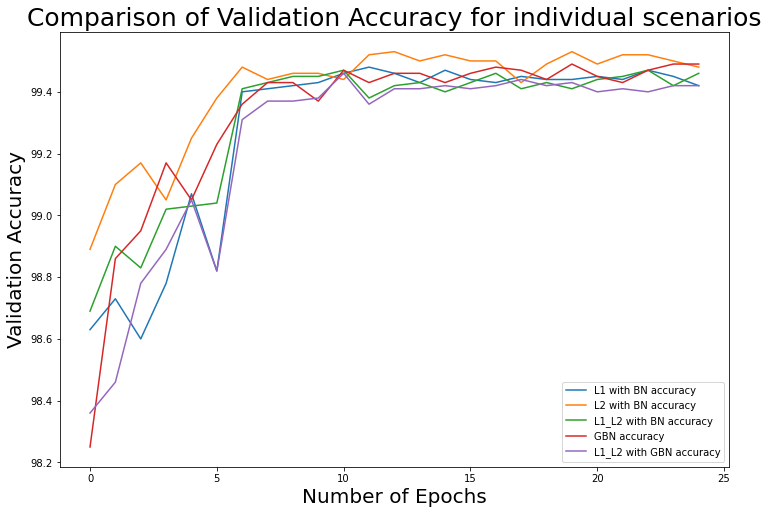

In [22]:
accuracy_df = pd.DataFrame({'L1 with BN accuracy': l1_acc, 'L2 with BN accuracy':l2_acc, 
                        'L1_L2 with BN accuracy':l1l2_acc, 'GBN accuracy':gbn_acc, 'L1_L2 with GBN accuracy': gbn_l1l2_acc})
fig, ax = plt.subplots(figsize = (12, 8))
acc_plot = accuracy_df.plot(ax = ax)
ax.set_title('Comparison of Validation Accuracy for individual scenarios', fontsize=25)
ax.set_xlabel('Number of Epochs', fontsize=20)
ax.set_ylabel('Validation Accuracy', fontsize=20)

## Find Misclassified Images

In [23]:
img_list = []
for i in gbn_misclassified:
  for j in range(i[0].shape[0]):
    img = i[0][j].cpu().numpy().squeeze()
    prediction = i[1][j].item()
    target = i[2][j].item()
    img_list.append((img, prediction, target))
img_list = img_list[:25]

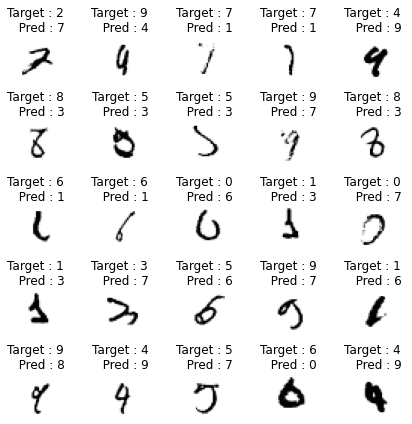

In [24]:
fig, axes = plt.subplots(5, 5, figsize = (6, 6))

for i, ax in enumerate(axes.flatten()):
    ax.axis('off')
    title = f'Target : {img_list[i][2]} \n  Pred : {img_list[i][1]}'
    ax.imshow(img_list[i][0], cmap = 'Greys')
    ax.set_title(title)
fig.tight_layout()